In [1]:
import os

def read_data_nmt():
    """载入“英语－法语”数据集"""
    data_dir = "../dataset"
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
             encoding='utf-8') as f:
        return f.read()

raw_text = read_data_nmt()
raw_text = raw_text.split('\n')
for idx, text in enumerate(raw_text):
    raw_text[idx] = text.split('CC-BY 2.0')[0]

print("总共" + str(len(raw_text)) + "组英语-法语对")
print("前5组英语-法语对示例：")

for i in range(5):
    print(raw_text[i])

raw_text = "\n".join(raw_text[:1000])

总共232737组英语-法语对
前5组英语-法语对示例：
Go.	Va !	
Go.	Marche.	
Go.	En route !	
Go.	Bouge !	
Hi.	Salut !	


In [2]:
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !	
go .	marche .	
go .	en route !	
go .	bouge !	
hi .	salut !	
hi .	salu


In [3]:
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 3:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['go', '.'],
  ['go', '.'],
  ['go', '.'],
  ['hi', '.'],
  ['hi', '.']],
 [['va', '!'],
  ['marche', '.'],
  ['en', 'route', '!'],
  ['bouge', '!'],
  ['salut', '!'],
  ['salut', '.']])

In [4]:
import collections

# 构建字典（词汇表：单词与索引之间的映射）
class Vocab:
    def __init__(self, tokens=None, min_freq=0, reversed_tokens=None):
        if tokens is None:
            tokens = []
        if reversed_tokens is None:
            reversed_tokens = []
        counter = self.count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True) # 词元出现的次数
        self.unk, uniq_tokens = 0, ['<unk>'] + reversed_tokens
        # 去除词频小于min_freq的词
        uniq_tokens += [token for token, freq in self.token_freqs
                        if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], {}
        # 构建词元和数字索引间的映射
        for i in range(len(uniq_tokens)):
            self.idx_to_token.append(uniq_tokens[i])
            self.token_to_idx[uniq_tokens[i]] = i

    # 返回字典的大小
    def __len__(self):
        return len(self.idx_to_token)

    # 获取词元的数字索引
    def __getitem__(self, tokens):
        # tokens 可以是单个单词，也可以是几个单词组成的一段文本
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_token(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[indice] for indice in indices]

    # 统计唯一词元和频率
    def count_corpus(self, tokens):
        if len(tokens) == 0 or isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line] # 取出所有的词元，组成一个一维列表
        return collections.Counter(tokens)

In [5]:
src_vocab = Vocab(source, min_freq=2, reversed_tokens=['<pad>', '<bos>', '<eos>'])
target_vocab = Vocab(target, min_freq=2, reversed_tokens=['<pad>', '<bos>', '<eos>'])
print("源语言字典大小：" + str(len(src_vocab)))
print("目标语言字典大小：" + str(len(target_vocab)))

源语言字典大小：217
目标语言字典大小：279


In [6]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[9, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [7]:
import numpy as np

def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = np.array([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).sum(1)
    return array, valid_len

In [8]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    # text = preprocess_nmt(read_data_nmt())
    # source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2, reversed_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2, reversed_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    print(len(src_vocab))
    print(len(src_array))
    print(len(src_array[0]))
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    # data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    # data_iter = load_array(data_arrays, batch_size)
    # return data_iter, src_vocab, tgt_vocab
    return src_array, tgt_array, src_vocab, tgt_vocab, src_valid_len, tgt_valid_len

In [9]:
import numpy as np

class GRU:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # Initialize weights
        self.W_z = np.random.randn(hidden_dim, input_dim)
        self.U_z = np.random.randn(hidden_dim, hidden_dim)
        self.b_z = np.zeros((hidden_dim, 1))

        self.W_r = np.random.randn(hidden_dim, input_dim)
        self.U_r = np.random.randn(hidden_dim, hidden_dim)
        self.b_r = np.zeros((hidden_dim, 1))

        self.W_h = np.random.randn(hidden_dim, input_dim)
        self.U_h = np.random.randn(hidden_dim, hidden_dim)
        self.b_h = np.zeros((hidden_dim, 1))

        self.V = np.random.randn(output_dim, hidden_dim)
        self.c = np.zeros((output_dim, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def forward(self, x):
        T = x.shape[1]
        batch_size = x.shape[0]

        h = np.zeros((batch_size, self.hidden_dim, T))
        h_t = np.zeros((batch_size, self.hidden_dim))

        for t in range(T):
            x_t = x[:, t].reshape(batch_size, self.input_dim)
            
            z_t = self.sigmoid(self.W_z @ x_t.T + self.U_z @ h_t.T + self.b_z)
            r_t = self.sigmoid(self.W_r @ x_t.T + self.U_r @ h_t.T + self.b_r)
            h_tilde_t = self.tanh(self.W_h @ x_t.T + self.U_h @ (r_t * h_t.T) + self.b_h)
            
            h_t = ((1 - z_t) * h_t.T + z_t * h_tilde_t).T
            h[:, :, t] = h_t
        
        # Compute the output
        y = self.V @ h_t.T + self.c

        return y, h

# Example usage
input_dim = 10
hidden_dim = 5
output_dim = 1
batch_size = 3
seq_length = 7

# Random input
x = np.random.randn(batch_size, seq_length, input_dim)

# Initialize GRU
gru = GRU(input_dim, hidden_dim, output_dim)

# Many-to-one output
y, h = gru.forward(x)
print("Many-to-one output:", y)

# Many-to-many output
print("Many-to-many hidden states:", h)


Many-to-one output: [[ 2.14973229 -0.12232977 -3.23072749]]
Many-to-many hidden states: [[[ 2.20192544e-02  6.64519955e-01  5.74260389e-01  9.90120376e-01
    9.98684428e-01  9.69214583e-01  9.32903096e-01]
  [ 7.64106102e-01  7.07661102e-01  9.39582250e-01  9.41354293e-01
    9.41439582e-01  6.70656623e-01  9.60939820e-01]
  [ 9.76861164e-01  3.53751601e-01 -9.18980627e-01 -9.05899837e-01
    6.78977136e-01  7.16504642e-01 -9.35224500e-01]
  [ 5.01573219e-01  9.90974761e-01  9.90946036e-01  9.91044151e-01
    9.91005596e-01  9.86126321e-01  9.93536235e-01]
  [ 3.04190974e-02 -9.93745190e-01  4.02630039e-01 -9.68895637e-01
   -7.72011779e-01 -8.33811908e-01  5.82990015e-01]]

 [[ 4.20261962e-01  1.83897945e-01 -9.88182782e-01  7.39101612e-02
    8.73067160e-01 -4.19624165e-01 -1.62015756e-01]
  [ 8.45695721e-04 -1.48352949e-01  4.14575088e-02 -2.00960283e-01
    2.93096044e-01 -1.36825217e-01 -9.74477446e-02]
  [ 4.46513996e-03 -9.95327193e-01 -8.76221217e-01 -8.57298984e-01
   -4.0177

In [10]:
def translate(sentence, seq2seq, source_vocab, target_vocab, num_steps):
    # Convert sentence to indices
    src_seq = sentence.lower().split(' ')
    print(src_seq)
    for idx, word in enumerate(src_seq):
        src_seq[idx] = source_vocab[word]
    src_seq = truncate_pad(src_seq, num_steps, src_vocab['<pad>'])
    print(src_seq)
    src_seq = np.eye(input_dim)[src_seq].T  # One-hot encoding

    # Initialize decoder input with <PAD> tokens
    tgt_seq_input = np.zeros((output_dim, num_steps))
    tgt_seq_input[target_vocab['<PAD>'], :] = 1

    output = seq2seq.forward(src_seq, tgt_seq_input)
    
    # Convert output indices to words
    translated_sentence = []
    for idx in np.argmax(output, axis=0):
        translated_sentence.append(target_vocab.to_token(idx))

    return " ".join(translated_sentence)

217
1000
8
input_dim: 217
hidden_dim: 50
output_dim: 279


  5%|▌         | 5/100 [00:12<03:54,  2.47s/it]

Epoch 5, Loss: 0.4171571420881243


 10%|█         | 10/100 [00:24<03:37,  2.41s/it]

Epoch 10, Loss: 0.2744019329681386


 15%|█▌        | 15/100 [00:36<03:25,  2.42s/it]

Epoch 15, Loss: 0.2369603886229093


 20%|██        | 20/100 [00:48<03:13,  2.42s/it]

Epoch 20, Loss: 0.23594038926947936


 25%|██▌       | 25/100 [01:00<03:02,  2.43s/it]

Epoch 25, Loss: 0.2362887662563756


 30%|███       | 30/100 [01:13<02:50,  2.43s/it]

Epoch 30, Loss: 0.2364982213960396


 35%|███▌      | 35/100 [01:25<02:36,  2.40s/it]

Epoch 35, Loss: 0.2365803274385458


 40%|████      | 40/100 [01:37<02:25,  2.42s/it]

Epoch 40, Loss: 0.23660955206567605


 45%|████▌     | 45/100 [01:49<02:12,  2.40s/it]

Epoch 45, Loss: 0.23661978972726247


 50%|█████     | 50/100 [02:01<02:01,  2.42s/it]

Epoch 50, Loss: 0.23662340182972585


 55%|█████▌    | 55/100 [02:13<01:48,  2.40s/it]

Epoch 55, Loss: 0.23662469098180422


 60%|██████    | 60/100 [02:25<01:36,  2.40s/it]

Epoch 60, Loss: 0.23662515567461445


 65%|██████▌   | 65/100 [02:37<01:24,  2.41s/it]

Epoch 65, Loss: 0.2366253243955459


 70%|███████   | 70/100 [02:49<01:11,  2.40s/it]

Epoch 70, Loss: 0.23662538595316018


 75%|███████▌  | 75/100 [03:01<01:00,  2.42s/it]

Epoch 75, Loss: 0.23662540848271346


 80%|████████  | 80/100 [03:13<00:48,  2.41s/it]

Epoch 80, Loss: 0.23662541674454993


 85%|████████▌ | 85/100 [03:25<00:36,  2.44s/it]

Epoch 85, Loss: 0.23662541977794646


 90%|█████████ | 90/100 [03:38<00:24,  2.49s/it]

Epoch 90, Loss: 0.23662542089251437


 95%|█████████▌| 95/100 [03:50<00:12,  2.43s/it]

Epoch 95, Loss: 0.23662542130222955


100%|██████████| 100/100 [04:02<00:00,  2.43s/it]

Epoch 100, Loss: 0.23662542145288276
训练完成


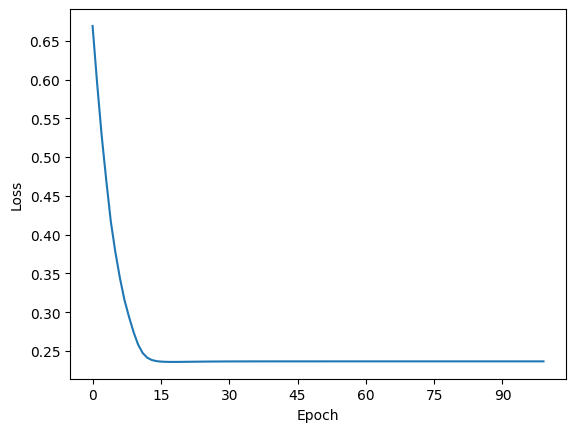

In [11]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import ticker

class EncoderGRU:
    def __init__(self, input_dim, hidden_dim):
        self.gru = GRU(input_dim, hidden_dim, hidden_dim)
        
    def forward(self, x):
        _, h = self.gru.forward(x)
        return h[:, :, -1]  # Return the last hidden state

class DecoderGRU:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.gru = GRU(input_dim, hidden_dim, output_dim)
        
    def forward(self, x, h):
        T = x.shape[1]
        batch_size = x.shape[0]
        output = np.zeros((batch_size, self.gru.output_dim, T))
        
        for t in range(T):
            x_t = x[:, t].reshape(batch_size, self.gru.input_dim)
            y_t, h = self.forward_step(x_t, h)
            output[:, :, t] = y_t
        
        return output, h
    
    def forward_step(self, x_t, h):
        z_t = self.gru.sigmoid(self.gru.W_z @ x_t.T + self.gru.U_z @ h.T + self.gru.b_z)
        r_t = self.gru.sigmoid(self.gru.W_r @ x_t.T + self.gru.U_r @ h.T + self.gru.b_r)
        h_tilde_t = self.gru.tanh(self.gru.W_h @ x_t.T + self.gru.U_h @ (r_t * h.T) + self.gru.b_h)
        h = ((1 - z_t) * h.T + z_t * h_tilde_t).T
        y_t = self.gru.V @ h.T + self.gru.c
        return y_t.T, h

class Seq2SeqGRU:
    def __init__(self, encoder, decoder):
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x_encoder, x_decoder):
        h = self.encoder.forward(x_encoder)
        output, _ = self.decoder.forward(x_decoder, h)
        return output

# 加载数据集
src_array, tgt_array, src_vocab, tgt_vocab, src_valid_len, tgt_valid_len = load_data_nmt(batch_size=2, num_steps=8)

# Hyperparameters
input_dim = len(src_vocab)
hidden_dim = 50
output_dim = len(target_vocab)

print("input_dim: {}\nhidden_dim: {}\noutput_dim: {}".format(input_dim, hidden_dim, output_dim))

# Initialize models
encoder_gru = EncoderGRU(input_dim, hidden_dim)
decoder_gru = DecoderGRU(output_dim, hidden_dim, output_dim)
seq2seq_gru = Seq2SeqGRU(encoder_gru, decoder_gru)

# Simple training loop (not using any framework, just for illustration)
learning_rate = 0.0001
num_epochs = 100

def cross_entropy_loss(output, target):
    m = target.shape[0]
    return -np.sum(np.log(output[np.arange(m), target])) / m

tot_loss = []
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    for src_seq, tgt_seq in zip(src_array, tgt_array):
        
        src_seq = np.eye(input_dim)[src_seq]  # One-hot encoding
        # print(src_seq.shape)
        tgt_seq_input = np.eye(output_dim)[tgt_seq[:-1]]  # Exclude last token for input
        tgt_seq_target = tgt_seq[1:] # Exclude first token for target

        output = seq2seq_gru.forward(np.expand_dims(src_seq, axis=0), np.expand_dims(tgt_seq_input, axis=0))
        output = np.squeeze(output, axis=0)

        output = np.exp(output) / np.sum(np.exp(output), axis=0)
        
        loss = cross_entropy_loss(output.T, tgt_seq_target)
        total_loss += loss
        
        # Backpropagation (gradient descent)
        # Simplified, normally you would need to implement backpropagation through time (BPTT)
        for param in [encoder_gru.gru.W_z, encoder_gru.gru.U_z, encoder_gru.gru.b_z,
                      encoder_gru.gru.W_r, encoder_gru.gru.U_r, encoder_gru.gru.b_r,
                      encoder_gru.gru.W_h, encoder_gru.gru.U_h, encoder_gru.gru.b_h,
                      encoder_gru.gru.V, encoder_gru.gru.c,
                      decoder_gru.gru.W_z, decoder_gru.gru.U_z, decoder_gru.gru.b_z,
                      decoder_gru.gru.W_r, decoder_gru.gru.U_r, decoder_gru.gru.b_r,
                      decoder_gru.gru.W_h, decoder_gru.gru.U_h, decoder_gru.gru.b_h,
                      decoder_gru.gru.V, decoder_gru.gru.c]:
            param -= learning_rate * param  # Simplified gradient descent update

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(raw_text)}")
    tot_loss.append(total_loss / len(raw_text))
print("训练完成")
_, ax = plt.subplots()
ax.plot(range(len(tot_loss)), tot_loss)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()